In [606]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')
%matplotlib notebook

In [607]:
xmax = 20 #max x values in m
ymax = 20 #max y values in m
zmax = 20 #max z values in m
h = 1 #amount of space each point represents in m**3

In [623]:
space_w = np.zeros((xmax, ymax, zmax*100))

In [624]:
dv = 1
dr = (dv)**(1/3)

# Wind

In [610]:
def sun_e(space, eavg=1.08e7, estd=1):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *eavg*
            int average value of energy from sun in J/m**2/day;
            default = 1.08e7 (average over Chicago)
        *estd*
            int standard deviation of energy from sun from eavg;
            default = 1
    :Returns:
        *energies*
            numpy.array values of energy from sun in J/m**2/day using
            edist with mean eavg
    '''
    eavg = eavg/(3600*24)
    energies = np.zeros(space.shape)
    for i in range(np.array(space.shape)[0]):
        for j in range(np.array(space.shape)[1]):
            e = np.random.normal(loc=eavg, scale=estd)
            energies[i, j, -1] = e

    return energies

# Cloud

In [611]:
def cloud(space, loc=(10,10,10), size=(10,1,1), hcloud=1, hmed=.95, hair=.69):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *loc*
            tuple location of center of cloud;
            default = (10,10,10)
        *size*
            tuple size of cloud;
            default = (10,1,1)
        *hcloud*
            int humidity of cloud;
            default = 1
        *hair*
            int humidity of air;
            default = 0
    :Returns:
        *humidities*
            numpy.array values of humidity
    '''
    assert all([i >= 0 for i in np.array(loc)-np.array(size)/2]) and \
    all([i >= 0 for i in np.array(space.shape)-np.array(loc)+np.array(size)/2]), \
    'Cloud must be within space.'

    humidities = space

    humidities[:][:][:] = hair

    n = np.array(size) % 2

    i = np.array(loc)[0]
    j = np.array(loc)[1]
    k = np.array(loc)[2]

    a0 = int(i-np.array(size)[0]/2)
    a1 = int(i+np.array(size)[0]/2) + n[0]
    b0 = int(j-np.array(size)[1]/2)
    b1 = int(j+np.array(size)[1]/2) + n[1]
    c0 = int(k-np.array(size)[2]/2)
    c1 = int(k+np.array(size)[2]/2) + n[2]

    humidities[a0-1:a1+1, b0-1:b1+1, c0-1:c1+1] = hmed
    humidities[a0:a1, b0:b1, c0:c1] = hcloud

    return humidities

# Tornado

In [612]:
def tornado(space, loc=10, lpress=10, rpress=1):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *loc*
            int location of pressure difference;
            default = 10

    :Returns:
        *pressures*
            numpy.array values of pressure
    '''
    assert 0 < loc and loc < np.array(space.shape)[0], 'Pressure difference must be within space.'

    pressures = altitude_pressures(space)

    pressures[loc:, :, :] *= rpress

    pressures[:loc, :, :] *= lpress

    return pressures

# Algorithm: Wind

In [613]:
def energytopressure(energies, dV):
    ps = energies/dV
    return ps

In [614]:
def altitude_pressures(space):
    pressures = space
    for h in range(np.array(space.shape)[2]):
        p = 101325*np.e**(-0.000119806*h)*np.random.normal(loc=1, scale=.00005)
        pressures[:, :, h] = abs(p)
    return pressures

In [615]:
def calc_J_air(pressures, D, dV=dv, T=329):
    R = 8.314598
    js = np.zeros([np.array(pressures.shape)[0], np.array(pressures.shape)[1], np.array(pressures.shape)[2], 9])
    for i in range(np.array(pressures.shape)[0]):
        for j in range(np.array(pressures.shape)[1]):
            for k in range(np.array(pressures.shape)[2]):
                p = pressures[i, j, k]

                n = p*dV/(R*T)
                phi = n/dV

                try:
                    assert i-1 != -1
                    pleft = pressures[i-1, j, k]
                    n = pleft*dV/(R*T)
                    phileft = n/dV
                    dphileft = phi - phileft
                except:
                    phileft = np.nan
                    dphileft = 0

                try:
                    pright = pressures[i+1, j, k]
                    n = pright*dv/(R*T)
                    phiright = n/dv
                    dphiright = phi - phiright
                except:
                    phiright = np.nan
                    dphiright = 0

                try:
                    assert j-1 != -1
                    pfront = pressures[i, j-1, k]
                    n = pfront*dV/(R*T)
                    phifront = n/dV
                    dphifront = phi - phifront
                except:
                    phifront = np.nan
                    dphifront = 0

                try:
                    pback = pressures[i, j+1, k]
                    n = pback*dV/(R*T)
                    phiback = n/dV
                    dphiback = phi - phiback
                except:
                    phiback = np.nan
                    dphiback = 0

                try:
                    assert k-1 != -1
                    pdown = pressures[i, j, k-1]
                    n = pdown*dV/(R*T)
                    phidown = n/dV
                    dphidown = phi - phidown
                except:
                    phidown = np.nan
                    dphidown = 0

                try:
                    pup = pressures[i, j, k+1]
                    n = pup*dV/(R*T)
                    phiup = n/dV
                    dphiup = phi - phiup
                except:
                    phiup = np.nan
                    dphiup = 0

                gradphix = (dphileft - dphiright)/2 #phiright-phileft
                gradphiy = (dphiback - dphifront)/2 #phifront-phiback
                gradphiz = (dphidown - dphiup)/2 #phiup-phidown

                gradphi = np.array([dphileft, dphiright, dphiback, dphifront, dphidown, dphiup,
                                    gradphix, gradphiy, gradphix])/(dV)**(1/3)
                J = -gradphi*D
                js[i, j, k, :] = J
    return js

In [616]:
def pressure_diffusion(pressures, D=1.76e-5, dV=dv, T=329, dt=1):
    js = calc_J_air(pressures, D)
    R = 8.314598
    Rarray = R*np.ones(pressures.shape)
    ns = np.divide(pressures*dV, Rarray*T)

    for i in range(np.array(pressures.shape)[0]):
        for j in range(np.array(pressures.shape)[1]):
            for k in range(np.array(pressures.shape)[2]):
                a = js[i, j, k, 0]*D*dt*np.random.normal(loc=1, scale=.2)
                b = js[i, j, k, 1]*D*dt*np.random.normal(loc=1, scale=.2)
                c = js[i, j, k, 2]*D*dt*np.random.normal(loc=1, scale=.2)
                d = js[i, j, k, 3]*D*dt*np.random.normal(loc=1, scale=.2)
                e = js[i, j, k, 4]*D*dt*np.random.normal(loc=1, scale=.2)
                f = js[i, j, k, 5]*D*dt*np.random.normal(loc=1, scale=.2)

                if a > 0:
                    ns[i, j, k] += a
                    ns[i-1, j, k] -= a

                if b > 0:
                    ns[i, j, k] += b
                    ns[i+1, j, k] -= b

                if c > 0:
                    ns[i, j, k] += c
                    ns[i, j+1, k] -= c

                if d > 0:
                    ns[i, j, k] += d
                    ns[i, j-1, k] -= d

                if e > 0:
                    ns[i, j, k] += e
                    ns[i, j, k-1] -= e

                if f > 0:
                    ns[i, j, k] += f
                    ns[i, j, k+1] -= f

    pressures = ns*R*T/dV
    return pressures

In [617]:
def integrate_from_sun(space, D=1.76e-5, dV=dv, tmax=20,
                       dt=1):
    pressures = np.zeros(space.shape)
    times = np.arange(0, tmax, dt)
    pt = np.zeros([len(times), np.array(space.shape)[0],
                   np.array(space.shape)[1], (np.array(space.shape)[2])])
    ps = altitude_pressures(space)
    for t in times:
        pt[t] = ps
        energies = sun_e(space)
        ps += energytopressure(energies, dV)
        ps = pressure_diffusion(ps, D=D, dt=dt)
    return pt

# Algorithm: Cloud

In [618]:
def calc_J_water(humidities, dV=dv, D=2.82e-5, T=329):
    js = np.zeros([np.array(humidities.shape)[0], np.array(humidities.shape)[1], np.array(humidities.shape)[2], 9])
    for i in range(np.array(humidities.shape)[0]):
        for j in range(np.array(humidities.shape)[1]):
            for k in range(np.array(humidities.shape)[2]):
                h = humidities[i, j, k]
                phi = h

                try:
                    assert i-1 != -1
                    hleft = humidities[i-1, j, k]
                    phileft = hleft
                    dphileft = phi - phileft
                except:
                    phileft = np.nan
                    dphileft = 0

                try:
                    hright = humidities[i+1, j, k]
                    phiright = hright
                    dphiright = phi - phiright
                except:
                    phiright = np.nan
                    dphiright = 0

                try:
                    assert j-1 != -1
                    hfront = humidities[i, j-1, k]
                    phifront = hfront
                    dphifront = phi - phifront
                except:
                    phifront = np.nan
                    dphifront = 0

                try:
                    hback = humidities[i, j+1, k]
                    phiback = hback
                    dphiback = phi - phiback
                except:
                    phiback = np.nan
                    dphiback = 0

                try:
                    assert k-1 != -1
                    hdown = humidities[i, j, k-1]
                    phidown = hdown
                    dphidown = phi - phidown
                except:
                    phidown = np.nan
                    dphidown = 0

                try:
                    hup = humidities[i, j, k+1]
                    phiup = hup
                    dphiup = phi - phiup
                except:
                    phiup = np.nan
                    dphiup = 0

                gradphix = (dphileft - dphiright)/2 #phiright-phileft
                gradphiy = (dphiback - dphifront)/2 #phifront-phiback
                gradphiz = (dphidown - dphiup)/2 #phiup-phidown

                gradphi = np.array([dphileft, dphiright, dphiback, dphifront, dphidown, dphiup,
                                    gradphix, gradphiy, gradphix])/(dV)**(1/3)
                J = -gradphi*D
                js[i, j, k, :] = J
    return js

In [619]:
def water_diffusion(humidities, D=2.82e-5, dV=dv, dt=1):
    js = calc_J_water(humidities, D=D)
    ns = humidities*dV

    for i in range(np.array(humidities.shape)[0]):
        for j in range(np.array(humidities.shape)[1]):
            for k in range(np.array(humidities.shape)[2]):
                a = js[i, j, k, 0]*dt*np.random.normal(loc=1, scale=.2)
                b = js[i, j, k, 1]*dt*np.random.normal(loc=1, scale=.2)
                c = js[i, j, k, 2]*dt*np.random.normal(loc=1, scale=.2)
                d = js[i, j, k, 3]*dt*np.random.normal(loc=1, scale=.2)
                e = js[i, j, k, 4]*dt*np.random.normal(loc=1, scale=.2)
                f = js[i, j, k, 5]*dt*np.random.normal(loc=1, scale=.2)

                if a > 0:
                    ns[i, j, k] += a
                    ns[i-1, j, k] -= a

                if b > 0:
                    ns[i, j, k] += b
                    ns[i+1, j, k] -= b

                if c > 0:
                    ns[i, j, k] += c
                    ns[i, j+1, k] -= c

                if d > 0:
                    ns[i, j, k] += d
                    ns[i, j-1, k] -= d

                if e > 0:
                    ns[i, j, k] += e
                    ns[i, j, k-1] -= e

                if f > 0:
                    ns[i, j, k] += f
                    ns[i, j, k+1] -= f

    humidities = ns/dV
    return humidities

In [620]:
def integrate_from_cloud(space, D=2.82e-5, loc=(10, 10, 10), size=(5, 1, 1), dV=dv, tmax=20,
                       dt=1):
    times = np.arange(0, tmax, dt)
    ht = np.zeros([len(times), np.array(space.shape)[0],
                   np.array(space.shape)[1], (np.array(space.shape)[2])])
    hs = cloud(space, loc=loc, size=size)
    for t in range(len(times)):
        ht[t] = hs
        hs = water_diffusion(hs, D=D, dt=dt)
    return ht

In [621]:
hs = cloud(space, loc=(10,10,10), size=(5,5,1))
js = calc_J_water(humidities, D=D)

In [622]:
ns = humidities*dV

for i in range(np.array(humidities.shape)[0]):
    for j in range(np.array(humidities.shape)[1]):
        for k in range(np.array(humidities.shape)[2]):
            a = js[i, j, k, 0]*np.random.normal(loc=1, scale=.2)
            b = js[i, j, k, 1]*np.random.normal(loc=1, scale=.2)
            c = js[i, j, k, 2]*np.random.normal(loc=1, scale=.2)
            d = js[i, j, k, 3]*np.random.normal(loc=1, scale=.2)
            e = js[i, j, k, 4]*np.random.normal(loc=1, scale=.2)
            f = js[i, j, k, 5]*np.random.normal(loc=1, scale=.2)

            if a > 0:
                print(a)
                ns[i, j, k] += a
                ns[i-1, j, k] -= a

            if b > 0:
                print(b)
                ns[i, j, k] += b
                ns[i+1, j, k] -= b

            if c > 0:
                print(c)
                ns[i, j, k] += c
                ns[i, j+1, k] -= c

            if d > 0:
                print(d)
                ns[i, j, k] += d
                ns[i, j-1, k] -= d

            if e > 0:
                print(e)
                ns[i, j, k] += e
                ns[i, j, k-1] -= e

            if f > 0:
                print(f)
                ns[i, j, k] += f
                ns[i, j, k+1] -= f

8.09928693827e-06
9.92504319217e-06
5.36908914295e-06
8.08413750614e-06
7.30069058055e-06
8.19201505781e-06
9.16669549552e-06
7.58912462406e-06
6.98772486341e-06
6.58578159213e-06
5.6447882722e-06
8.48970253762e-06
5.09530731172e-06
7.07285222905e-06
8.81091726052e-06
6.45939122071e-06
5.83233651513e-06
9.10980962538e-06
6.78006618289e-06
5.63193111544e-06
4.05656465795e-06
6.71462868063e-06
8.96342558838e-06
1.63646956443e-06
1.44429910698e-06
1.10960476184e-05
5.80494828902e-06
1.09746171142e-06
1.09458579365e-06
7.66373783719e-06
9.25106335569e-06
6.27519405768e-06
5.92722320887e-06
4.63043571503e-06
5.70487270503e-06
9.28601290257e-06
6.63172172666e-06
9.08194984313e-06
7.24034859765e-06
7.04200312534e-06
7.13937409551e-06
1.60803782424e-06
1.1215073569e-06
7.05810653526e-06
6.85189829951e-06
9.62187635768e-07
1.36589380718e-06
6.58238170781e-06
7.26314858471e-06
1.25810183744e-06
1.48781846098e-06
5.59614703237e-06
7.52276451451e-06
1.69627158942e-06
1.83474107317e-06
6.3164103098

# Algorithm: Tornado

In [137]:
def plot_surf_w(y_t, Dt=dr, Dx=dr, step=1, filename=None, offset=-1,
             elevation=40, azimuth=20, cmap=plt.cm.viridis):
    """Plot y_t as a 3D plot with contour plot underneath.
    
    Arguments
    ---------
    y_t : 2D array
          displacement y(t, x)
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    offset : float, optional (default: 20)
          position the 2D contour plot by offset along the Z direction
          under the minimum Z value
    zlabel : string, optional
          label for the Z axis and color scale bar
    elevation : float, optional
          choose elevation for initial viewpoint
    azimuth : float, optional
          chooze azimuth angle for initial viewpoint
    """
     
    t = np.arange(y_t.shape[0])
    x = np.arange(y_t.shape[1])
    T, X = np.meshgrid(t, x)
    Y = y_t.T[X, T]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X*Dx, T*Dt*step, Y, cmap=cmap, rstride=1, cstride=1, alpha=1)
    cset = ax.contourf(X*Dx, T*Dt*step, Y, 20, zdir='z', offset=offset+Y.min(), cmap=cmap)

    ax.set_ylabel(r'x position $x$ (m)')
    ax.set_xlabel(r'z position $z$ (m)')
    ax.set_zlabel(r'Pressure $P$ (Pa)')
    ax.set_zlim(offset + Y.min(), Y.max())
    
    ax.view_init(elev=elevation, azim=azimuth)

    cb = fig.colorbar(surf, shrink=0.5, aspect=5)
    cb.set_label('pressure')
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax

def plot_y(y_t, Dx=dr, Dt=dr, step=1):
    X, Y = np.meshgrid(range(y_t.shape[0]), range(y_t.shape[1]))
    Z = y_t.T[Y, X]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_wireframe(Y*Dx, X*Dt*step, Z)
    ax.set_xlabel(r'x position $x$ (m)')
    ax.set_ylabel(r'z position $z$ (m)')
    ax.set_zlabel(r'Pressure $P$ (Pa)')
    fig.tight_layout()
    return ax

In [138]:
pt = integrate_from_sun(space_w, tmax=86400)

In [ ]:
ax0 = plot_surf_w(pt[0,:,10,:], filename='initial_wind_day')

ax1 = plot_surf_w(pt[1,:,10,:], filename='step1_wind_day')

ax10 = plot_surf_w(pt[10,:,10,:], filename='step10_wind_day')

ax100 = plot_surf_w(pt[100,:,10,:], filename='step100_wind_day')

ax200 = plot_surf_w(pt[200,:,10,:], filename='step200_wind_day')

ax300 = plot_surf_w(pt[300,:,10,:], filename='step300_wind_day')

ax400 = plot_surf_w(pt[400,:,10,:], filename='step400_wind_day')

ax500 = plot_surf_w(pt[500,:,10,:], filename='step500_wind_day')

ax600 = plot_surf_w(pt[600,:,10,:], filename='step600_wind_day')

ax1439 = plot_surf_w(pt[1439,:,10,:], filename='end_wind_day')

ax700 = plot_surf_w(pt[700,:,10,:], filename='step700_wind_day')

ax800 = plot_surf_w(pt[800,:,10,:], filename='step800_wind_day')

ax900 = plot_surf_w(pt[900,:,10,:], filename='step900_wind_day')

ax1000 = plot_surf_w(pt[1000,:,10,:], filename='step1000_wind_day')

ax1100 = plot_surf_w(pt[1100,:,10,:], filename='step1100_wind_day')

ax1200 = plot_surf_w(pt[1200,:,10,:], filename='step1200_wind_day')

ax1300 = plot_surf_w(pt[1300,:,10,:], filename='step1300_wind_day')

ax1400 = plot_surf_w(pt[1400,:,10,:], filename='step1400_wind_day')

In [625]:
def plot_surf_c(y_t, Dt=dr, Dx=dr, step=1, filename=None, offset=-1,
             elevation=40, azimuth=20, cmap=plt.cm.magma):
    """Plot y_t as a 3D plot with contour plot underneath.
    
    Arguments
    ---------
    y_t : 2D array
          displacement y(t, x)
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    offset : float, optional (default: 20)
          position the 2D contour plot by offset along the Z direction
          under the minimum Z value
    zlabel : string, optional
          label for the Z axis and color scale bar
    elevation : float, optional
          choose elevation for initial viewpoint
    azimuth : float, optional
          chooze azimuth angle for initial viewpoint
    """
     
    t = np.arange(y_t.shape[0])
    x = np.arange(y_t.shape[1])
    T, X = np.meshgrid(t, x)
    Y = y_t.T[X, T]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X*Dx, T*Dt*step, Y, cmap=cmap, rstride=1, cstride=1, alpha=1)
    cset = ax.contourf(X*Dx, T*Dt*step, Y, 20, zdir='z', offset=offset+Y.min(), cmap=cmap)

    ax.set_ylabel(r'x position $x$ (m)')
    ax.set_xlabel(r'z position $z$ (m)')
    ax.set_zlabel(r'humidity $h$ (%)')
    ax.set_zlim(offset + Y.min(), Y.max())
    
    ax.view_init(elev=elevation, azim=azimuth)

    cb = fig.colorbar(surf, shrink=0.5, aspect=5)
    cb.set_label('humidity')
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax

In [ ]:
ht = integrate_from_cloud(space, tmax=86400, dt=60)

In [149]:
tmax=86400
dt=60
times = np.arange(0, tmax, dt)
ht = np.zeros([len(times), np.array(space.shape)[0],
               np.array(space.shape)[1], (np.array(space.shape)[2])])
hs = cloud(space, loc=(10,10,10), size=(5, 1, 1))
for t in range(len(times)):
    ht[t] = hs
    hs = water_diffusion(hs, D=D, dt=dt)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


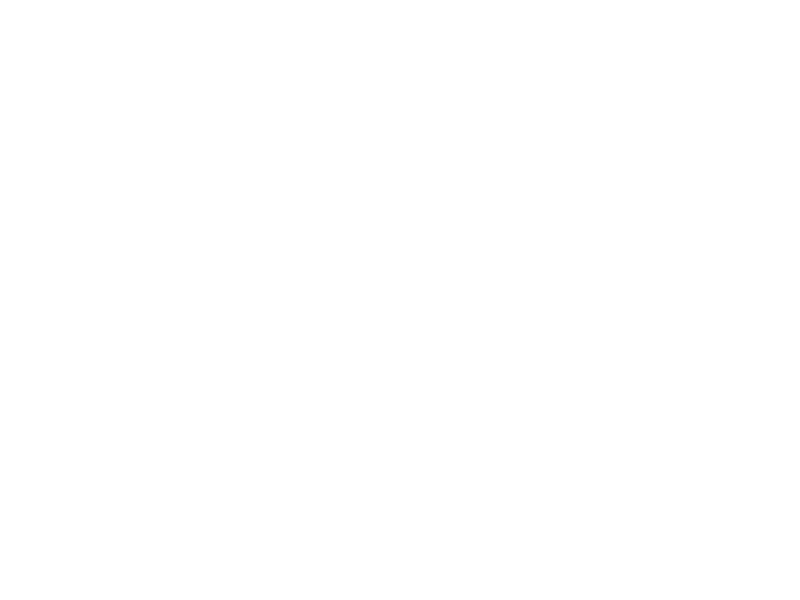

In [152]:
ax0 = plot_surf_c(ht[0,:,10,:], filename='initial_cloud_day')

ax1 = plot_surf_c(ht[1,:,10,:], filename='step1_cloud_day')

ax10 = plot_surf_c(ht[10,:,10,:], filename='step10_cloud_day')

ax100 = plot_surf_c(ht[100,:,10,:], filename='step100_cloud_day')

ax200 = plot_surf_c(ht[200,:,10,:], filename='step200_cloud_day')

ax300 = plot_surf_c(ht[300,:,10,:], filename='step300_cloud_day')

ax400 = plot_surf_c(ht[400,:,10,:], filename='step400_cloud_day')

ax500 = plot_surf_c(ht[500,:,10,:], filename='step500_cloud_day')

ax600 = plot_surf_c(ht[600,:,10,:], filename='step600_cloud_day')

ax1439 = plot_surf_c(ht[1439,:,10,:], filename='end_cloud_day')

ax1439 = plot_surf_c(ht[1439,:,10,:])

ax700 = plot_surf_c(ht[700,:,10,:], filename='step700_cloud_day')

ax800 = plot_surf_c(ht[800,:,10,:], filename='step800_cloud_day')

ax900 = plot_surf_c(ht[900,:,10,:], filename='step900_cloud_day')

ax1000 = plot_surf_c(ht[1000,:,10,:], filename='step1000_cloud_day')

ax1100 = plot_surf_c(ht[1100,:,10,:], filename='step1100_cloud_day')

ax1200 = plot_surf_c(ht[1200,:,10,:], filename='step1200_cloud_day')

ax1300 = plot_surf_c(ht[1300,:,10,:], filename='step1300_cloud_day')

ax1400 = plot_surf_c(ht[1400,:,10,:], filename='step1400_cloud_day')